In [404]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t, skew, kurtosis
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
#Problem 1
n = 100000
sim = np.random.randn(n)
#create function for kurtosis skewness calculation
def calKurtosisSkewness(sample):
    n = sample.size
    μ_hat = sum(sample)/n
    m = np.ones(n) * μ_hat
    sim_corrected = sample - m
    sim_c_t = sim_corrected.T
    cm2 = sum(sim_c_t*sim_corrected)/n
    sq = np.sqrt(cm2*cm2*cm2)
    skew_hat = sum(sim_corrected**3)/n/sq
    kurt_hat = sum(sim_corrected**4)/n/cm2**2
    excess_kurt = kurt_hat - 3
    return skew_hat, excess_kurt
#create the amount of repeatition
samples = 100
temp = []
kurt = []
skew = []
for i in range (0, samples):
    temp.append(calKurtosisSkewness(np.random.randn(n)))
for j in range (0, len(temp)):
    skew.append(temp[j][0])
for h in range(0, len(temp)):
    kurt.append(temp[h][1])
#calculate the average of 100 results
exkurt_func = sum(kurt)/len(kurt)
skew_func = sum(skew)/len(skew)
print("skewness calculated from my function:", skew_func)
print("excess kurtosis calculated from my function:", exkurt_func)


skewness calculated from my function: 0.000879526566848134
excess kurtosis calculated from my function: 0.002331341596139347


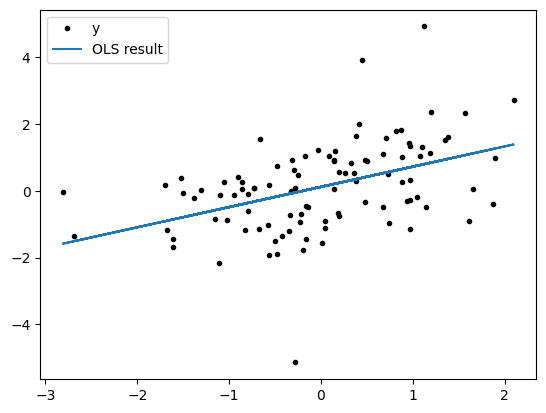

In [405]:
#Probelm 2

#Question A
my_data = np.genfromtxt('problem2.csv', delimiter=',')
my_data = np.delete(my_data, 0, 0)
x_d = my_data[:, 0].reshape(-1, 1)
y_d = my_data[:, 1].reshape(-1, 1)
model = LinearRegression()
model.fit(x_d, y_d)
prediction_y_d = model.predict(x_d)
plt.figure()
plt.plot(x_d, y_d, 'k.', label = 'y')
plt.plot(x_d, prediction_y_d, label = 'OLS result')
plt.legend()
plt.show()

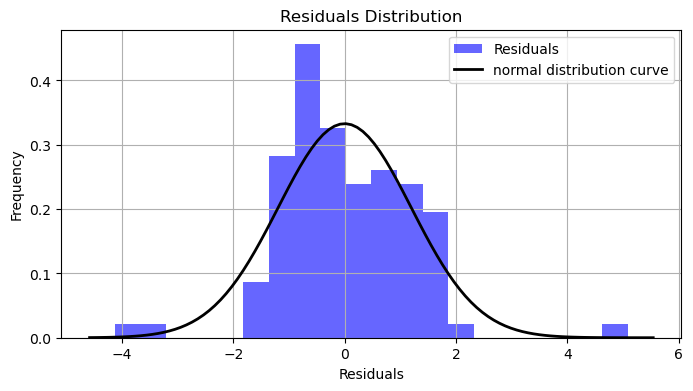

In [406]:
#calculate error vector and plot the hist
residuals = (prediction_y_d - y_d)
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=20, density=True, alpha=0.6, color='b', label='Residuals')

mu, std = norm.fit(residuals)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

# Plot the fitted normal distribution
plt.plot(x, p, 'k', linewidth=2,label = 'normal distribution curve')

plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.legend()
plt.grid(True)
plt.show()

In [407]:
#Question B
#create class for MLE fitting
class MLE:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    #normal distribution
    def normal_nll(self, p):
        m_hat = p[0]   
        b = p[1]
        sigma = p[2]
        error_dist = norm(0, sigma)
        error_term = self.y - b - m_hat * self.x
        nll = -np.log(error_dist.pdf(error_term)).sum()
        return nll
    
    #t distribution
    def t_nll(self, p):
        m_hat = p[0]   
        b = p[1]
        df = p[2]
        scale = p[3]
        error_dist = t(df, scale)
        error_term = self.y - b - m_hat * self.x
        nll = -np.log(error_dist.pdf(error_term)).sum()
        return nll
    
    # optimization for normal dirtribution
    def normal_optimization(self, init_p):
        result = minimize(self.normal_nll, init_p, method='BFGS')
        return result
    
    # optimization for t distribution
    def t_optimization(self, init_p):
        result = minimize(self.t_nll, init_p, method='BFGS')
        return result


In [408]:
# Assuming MLE, x_d and y_d are already defined
# Instantiate the MLE class for data x_d and y_d
mle = MLE(x_d, y_d)

# Initialize initial parameters for optimization
init_params_norm = [1, 1, 1]
init_params_t = [1, 1, 1, 1]

# Perform optimization assuming normally-distributed errors
try:
    result_norm = mle.normal_optimization(init_params_norm)
except Exception as e:
    print(f"Normal optimization failed: {e}")
    result_norm = None

# Perform optimization assuming t-distributed errors
try:
    result_t = mle.t_optimization(init_params_t)
except Exception as e:
    print(f"T-distribution optimization failed: {e}")
    result_t = None

# Compute predicted values and metrics if optimizations were successful
if result_norm is not None:
    m_norm, b_norm = result_norm.x[0], result_norm.x[1]
    y_pred_mle_norm = m_norm * x_d + b_norm
    
    SSE_norm = np.square(y_pred_mle_norm - y_d).sum()
    AIC_norm = 2 * len(result_norm.x) - 2 * (-result_norm.fun)
    BIC_norm = len(result_norm.x) * np.log(len(y_d)) - 2 * (-result_norm.fun)
    print(f"SSE for normal distribution: {SSE_norm}, AIC: {AIC_norm}, BIC: {BIC_norm}")

if result_t is not None:
    m_t, b_t = result_t.x[0], result_t.x[1]
    y_pred_mle_t = m_t * x_d + b_t
    
    SSE_t = np.square(y_pred_mle_t - y_d).sum()
    AIC_t = 2 * len(result_t.x) - 2 * (-result_t.fun)
    BIC_t = len(result_t.x) * np.log(len(y_d)) - 2 * (-result_t.fun)
    print(f"SSE for t-distribution: {SSE_t}, AIC: {AIC_t}, BIC: {BIC_t}")

SSE for normal distribution: 143.61484854062613, AIC: 325.9841933783248, BIC: 333.79970393628906
SSE for t-distribution: 144.06627090325546, AIC: 319.030574551578, BIC: 329.45125529553036


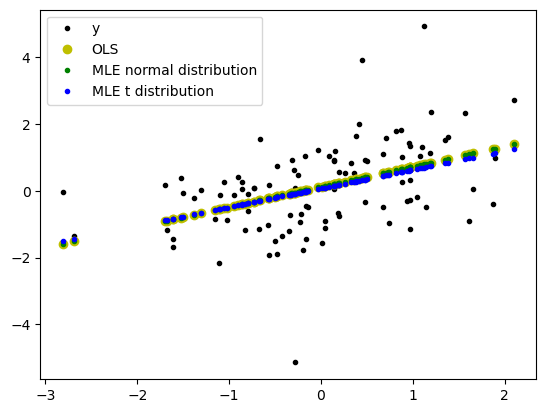

In [409]:
# OLS, MLE normal dist and MLE t dist plot
plt.figure()
plt.plot(x_d, y_d, 'k.', label='y')
plt.plot(x_d, prediction_y_d, 'yo', label='OLS')
plt.plot(x_d, y_pred_mle_norm, 'g.', label='MLE normal distribution')
plt.plot(x_d, y_pred_mle_t, 'b.', label='MLE t distribution')
plt.legend()
plt.show()

c:\Users\11692\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


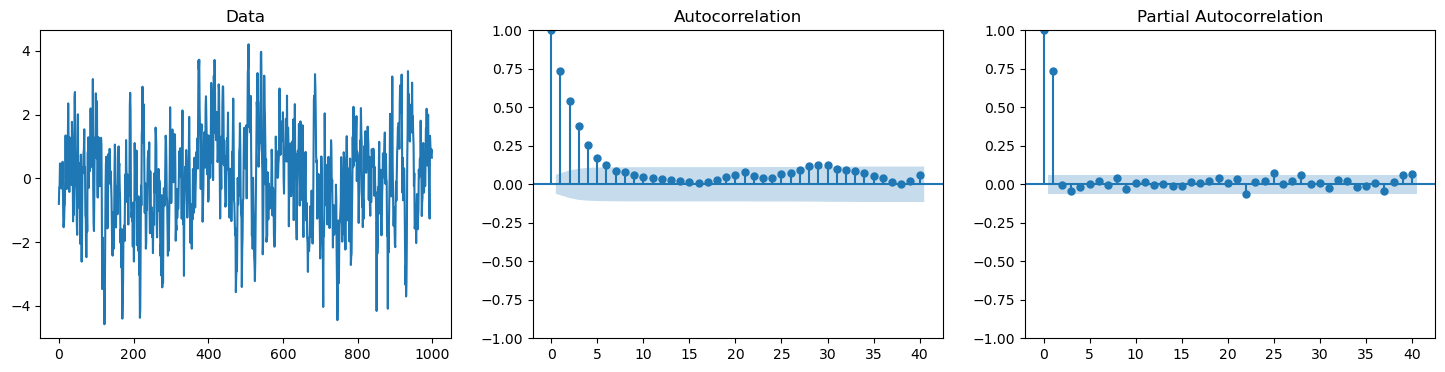

c:\Users\11692\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

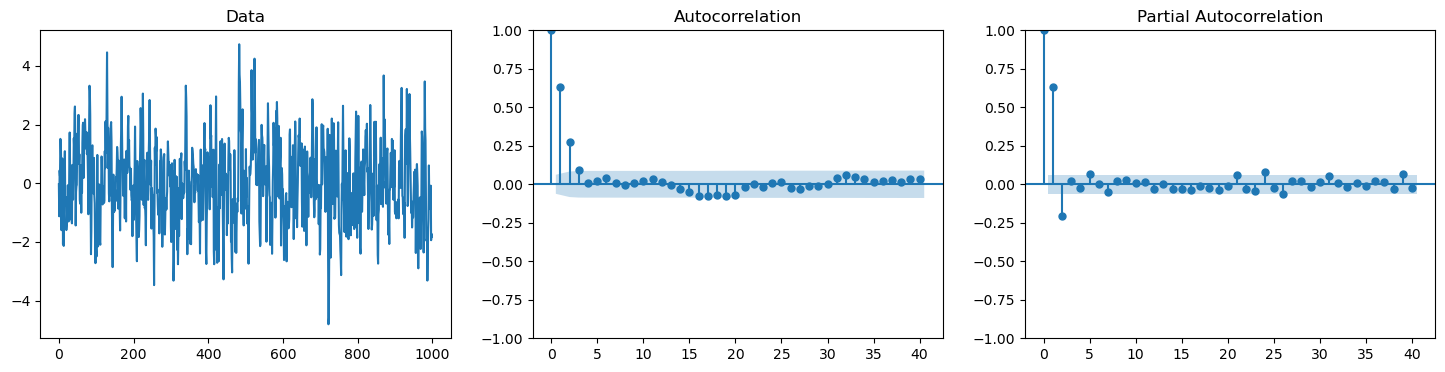

c:\Users\11692\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

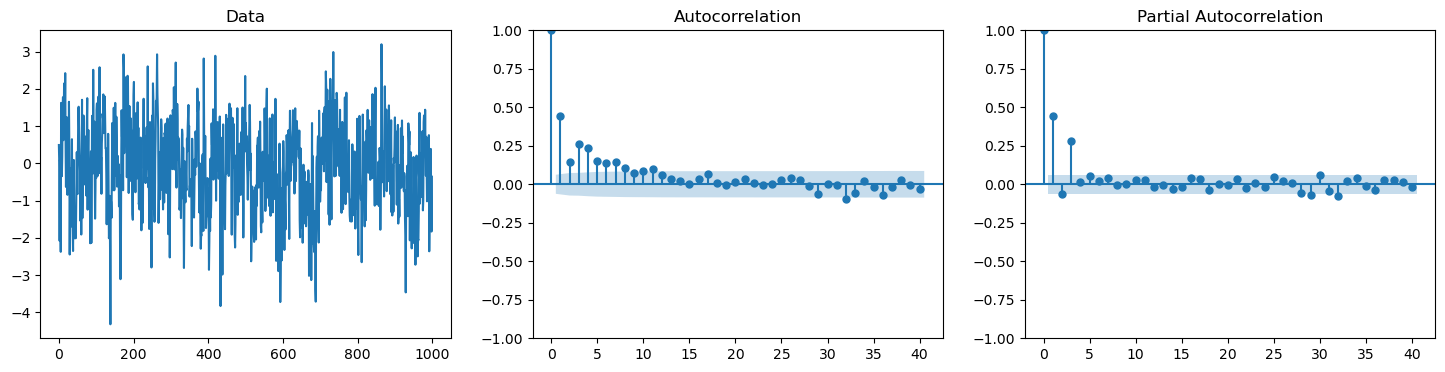

Text(0.5, 0.98, 'AR(3)')

<Figure size 640x480 with 0 Axes>

In [410]:
# Function to plot Simulation, ACF and PACF
def plot_simulation_acf_pacf(ts, lags=40):
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    
    # Plotting the simulated data
    ax[0].plot(ts)
    ax[0].set_title('Data')
    
    # Plotting ACF
    sm.graphics.tsa.plot_acf(ts, lags=lags, ax=ax[1])
    
    # Plotting PACF
    sm.graphics.tsa.plot_pacf(ts, lags=lags, ax=ax[2])
    
    plt.show()

# Simulate and plot AR(1)
np.random.seed(1000)
ar1 = np.array([1, -0.75])
ma1 = np.array([1])
AR1_process = ArmaProcess(ar1, ma1)
AR1_simulated = AR1_process.generate_sample(nsample=1000)
plot_simulation_acf_pacf(AR1_simulated)
plt.suptitle('AR(1)')

# Simulate and plot AR(2)
ar2 = np.array([1, -0.75, 0.25])
ma1 = np.array([1])
AR2_process = ArmaProcess(ar2, ma1)
AR2_simulated = AR2_process.generate_sample(nsample=1000)
plot_simulation_acf_pacf(AR2_simulated)
plt.suptitle('AR(2)')

# Simulate and plot AR(3)
ar3 = np.array([1, -0.5, 0.25, -0.3])
ma1 = np.array([1])
AR3_process = ArmaProcess(ar3, ma1)
AR3_simulated = AR3_process.generate_sample(nsample=1000)
plot_simulation_acf_pacf(AR3_simulated)
plt.suptitle('AR(3)')


c:\Users\11692\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


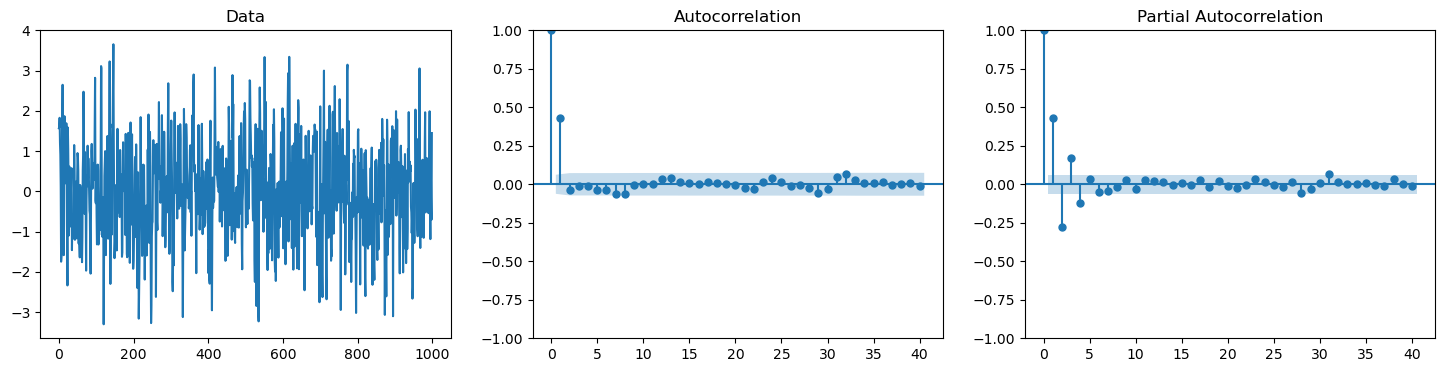

c:\Users\11692\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

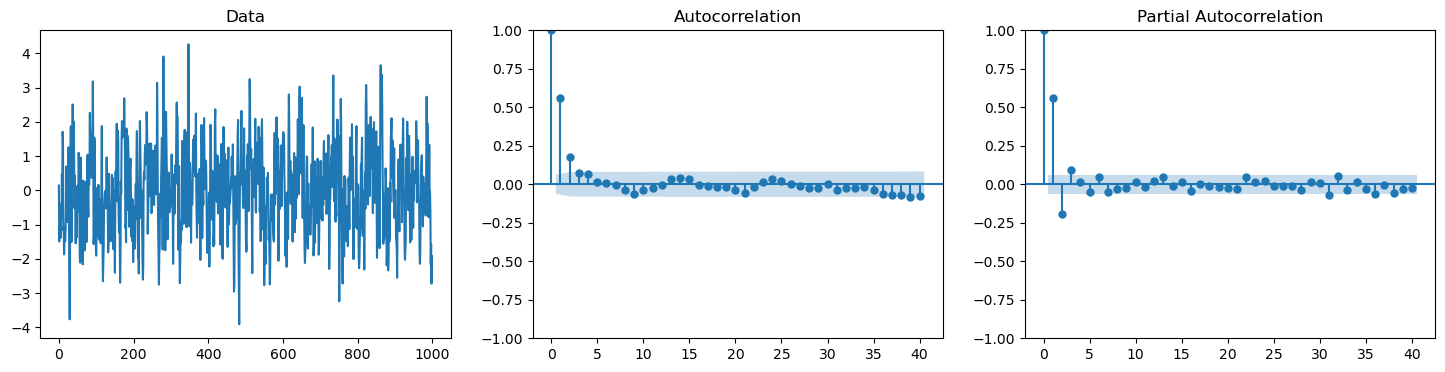

c:\Users\11692\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

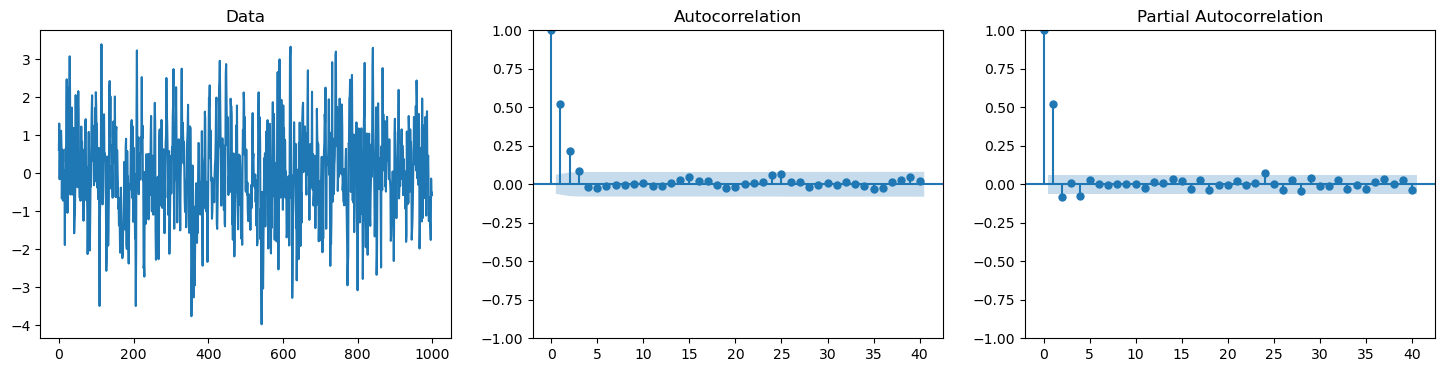

Text(0.5, 0.98, 'MA(3)')

<Figure size 640x480 with 0 Axes>

In [411]:
# Simulate and plot MA(1)
ar1 = np.array([1])
ma1 = np.array([1, 0.7])
MA1_process = ArmaProcess(ar1, ma1)
MA1_simulated = MA1_process.generate_sample(nsample=1000)
plot_simulation_acf_pacf(MA1_simulated)
plt.suptitle('MA(1)')

# Simulate and plot MA(2)
ar1 = np.array([1])
ma2 = np.array([1, 0.7, 0.2])
MA2_process = ArmaProcess(ar1, ma2)
MA2_simulated = MA2_process.generate_sample(nsample=1000)
plot_simulation_acf_pacf(MA2_simulated)
plt.suptitle('MA(2)')

# Simulate and plot MA(3)
ar1 = np.array([1])
ma3 = np.array([1, 0.6, 0.2, 0.1])
MA3_process = ArmaProcess(ar1, ma3)
MA3_simulated = MA3_process.generate_sample(nsample=1000)
plot_simulation_acf_pacf(MA3_simulated)
plt.suptitle('MA(3)')